<a href="https://colab.research.google.com/github/adeshkadambi/EgoVizModeling/blob/colab/notebooks/all_model_evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install torchmetrics
!pip install matplotlib --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 6.6 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
import glob
import json
import torch
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
%cd /content/drive/MyDrive/PhD/object-detection-eval-subset/

/content/drive/MyDrive/PhD/object-detection-eval-subset


In [4]:
from torchvision.ops import box_iou
from typing import List, Union

def load_pickle(file_path: str):
    """
    Load data from a pickle file.

    Parameters
    ----------
    file_path : str
        The path to the pickle file to load.

    Returns
    -------
    data : object
        The data loaded from the pickle file.
    """
    with open(file_path, 'rb') as f:
        data = pickle.load(f)
    return data

def save_pickle(data, file_path: str):
    """
    Save data to a pickle file.

    Parameters
    ----------
    data : object
        The data to save.
    file_path : str
        The path to the pickle file to save to.
    """
    with open(file_path, 'wb') as f:
        pickle.dump(data, f)

def remap_classes_detic(classes: List[int], mapping_df: pd.DataFrame):
    """
    Remap a list of classes using a mapping dataframe.

    Parameters
    ----------
    classes : List[int]
        The list of class ids to remap.
    mapping_df : pd.DataFrame
        A DataFrame where the index is the original class id 
        and the 'remapped_classes' column contains the new class names.

    Returns
    -------
    remapped_classes : List[str]
        The list of remapped class names.
    """
    remapped_classes = [mapping_df.loc[c, 'remapped_classes'] for c in classes]
    return remapped_classes

def remap_classes_unidet(classes: List[Union[int, str]], mapping_dict: dict):
    remapped_classes = []
    for c in classes:
        for class_name, data in mapping_dict.items():
            if isinstance(c, int):
                if c in data['subclasses']:
                    remapped_classes.append(data['label'])
                    break
            elif isinstance(c, str):
                c = c.replace('_', ' ')
                if c in data['subclasses_names']:
                    remapped_classes.append(data['label'])
                    break
        else:
            remapped_classes.append('background')
    return remapped_classes

def identify_active_objects(detic_boxes, shan_boxes):
    """
    Identify active objects by comparing IoU of boxes.

    Parameters
    ----------
    detic_boxes : List[List[float]]
        The list of bounding boxes detected by detic.
    shan_boxes : List[List[float]]
        The list of bounding boxes detected by shan.

    Returns
    -------
    active : List[bool]
        A list of boolean values where True means the object is active 
        (i.e., its IoU with a shan detected object is 0.75 or more).
    """
    if shan_boxes is not None:

      if len(detic_boxes) == 0 or len(shan_boxes) == 0:
          return np.array([])

      detic_boxes = np.array(detic_boxes).astype(int)
      shan_boxes = np.array([obj[0:4] for obj in shan_boxes]).astype(int)
      ious = box_iou(torch.tensor(detic_boxes), torch.tensor(shan_boxes))
      active = [any(ious[i] >= 0.75) for i in range(len(detic_boxes))]
      return active

    else:
      return np.array([])

def filter_out_class_id(data, class_id_to_filter):
    """
    Filter out instances of a certain class id from a data dictionary.

    Parameters
    ----------
    data : dict
        A dictionary containing 'boxes', 'scores', 'classes', and 'metadata' lists.
    class_id_to_filter : int
        The class id to filter out.

    Returns
    -------
    data : dict
        A new dictionary with only instances that don't have the class id to filter.
    """
    indices_to_keep = [i for i, class_id in enumerate(data['classes']) if class_id != class_id_to_filter]
    
    data['boxes'] = [data['boxes'][i] for i in indices_to_keep]
    data['scores'] = [data['scores'][i] for i in indices_to_keep]
    data['classes'] = [data['classes'][i] for i in indices_to_keep]
    data['metadata'] = [data['metadata'][i] for i in indices_to_keep]
    
    return data

In [5]:
# Loop through the adl_classes and images
adl_classes = ['communication-mgmt', 'functional-mobility', 'grooming-health-mgmt', 'home-management', 'leisure-other', 'meal-prep-cleanup', 'self-feeding']

### Ground Truth

In [6]:
load_gt = True #@param ["False", "True"] {type:"raw"}

if not load_gt:
  # Load mapping dictionary
  mapping_dict = load_pickle('/content/drive/MyDrive/PhD/object-detection-eval-subset/new_mapper.pkl')

  # Load the JSON data
  with open('/content/drive/MyDrive/PhD/object-detection-eval-subset/ground_truth_labels.json', 'r') as f:
      data = json.load(f)

  processed_data = []

  # Iterate over all entries in the json file
  for entry in data:
      if not entry['Skipped']:
        ground_truth = {}

        # Set the name
        ground_truth['name'] = f"{entry['Dataset Name']}_{entry['External ID']}"
        
        # Get bounding box coordinates and convert them to the [x1, y1, x2, y2] format
        boxes = []
        for obj in entry['Label']['objects']:
            bbox = obj['bbox']
            x1, y1 = bbox['left'], bbox['top']
            x2, y2 = x1 + bbox['width'], y1 + bbox['height']
            boxes.append([x1, y1, x2, y2])
        ground_truth['boxes'] = np.array(boxes, dtype=int)

        # Get the class labels
        ground_truth['classes'] = [obj['value'] for obj in entry['Label']['objects']]

        # Remap the classes
        ground_truth['remapped_classes'] = remap_classes_unidet(ground_truth['classes'], mapping_dict)
        
        # Load corresponding shan data
        shan_data_path = glob.glob(f"/content/drive/MyDrive/PhD/object-detection-eval-subset/dataset/{entry['Dataset Name']}/shan/{entry['External ID'].replace('.jpg', '')}_shan.pkl")
        if shan_data_path:
            shan_data = load_pickle(shan_data_path[0])
            # Identify active objects
            ground_truth['active'] = identify_active_objects(ground_truth['boxes'], shan_data['objects'])
        else:
            ground_truth['active'] = []

        processed_data.append(ground_truth)
      else:
        continue

  # Save the processed data
  save_pickle(processed_data, "/content/drive/MyDrive/PhD/object-detection-eval-subset/dataset/processed_ground_truth.pkl")
else:
  processed_data = load_pickle("/content/drive/MyDrive/PhD/object-detection-eval-subset/dataset/processed_ground_truth.pkl")

In [7]:
# Load your mapping from the spreadsheet
df = pd.read_excel('/content/drive/MyDrive/PhD/object-detection-eval-subset/ontology.xlsx', sheet_name='cats').dropna()

# Create a dictionary to map from string labels to integer IDs
mapping = {}
for label, classes in zip(df['labels'], df['classes']):
    # Normalize label
    norm_label = label.replace(" ", "").replace("/", "").replace("&", "").lower()
    if isinstance(classes, int):
        mapping[norm_label] = classes
    else:
        classes = list(map(int, classes.split(',')))  # convert to list of integers
        mapping[norm_label] = classes[0]

for img_data in processed_data:
    labels = img_data['classes']
    class_ids = []
    for label in labels:
        norm_label = label.replace('_','').replace(" ", "").replace("/", "").lower()  # Normalize the label
        if norm_label in mapping:
            class_ids.append(mapping[norm_label])
        else:
            print(f"Label '{norm_label}' could not be mapped to a class ID.")
    img_data['class_ids'] = class_ids

In [8]:
len(processed_data)

1169

In [9]:
processed_data[0]

{'name': 'communication-mgmt_SCI06-7--11_frame49.jpg',
 'boxes': array([[ 982,  524, 1258,  960],
        [   0,  158,  747,  671],
        [1437,   53, 1920,  944],
        [ 460,  401,  533,  613]]),
 'classes': ['cell_phonemobile_phone', 'chair', 'chair', 'remote'],
 'remapped_classes': ['phone_tablet', 'furniture', 'furniture', 'electronics'],
 'active': [True, False, False, False],
 'class_ids': [153, 135, 135, 6]}

### Detic

In [10]:
save_detic_pickles = False #@param ["False", "True"] {type:"raw"}
custom_vocabulary = False #@param ["False", "True"] {type:"raw"}

# Load the mapping spreadsheet
mapping_df = pd.read_excel('/content/drive/MyDrive/PhD/object-detection-eval-subset/ontology.xlsx', sheet_name='LVIS').set_index('class_ids')

for adl_class in adl_classes:
    for img_name in glob.glob(f'dataset/{adl_class}/unidet/*.jpg'):
        img_name = os.path.splitext(img_name)[0].split('/')[-1]
        
        # Load detic and shan data
        if custom_vocabulary:
          detic_data = load_pickle(f'dataset/{adl_class}/detic/{img_name}_detic_custom.pkl')
        else:
          detic_data = load_pickle(f'dataset/{adl_class}/detic/{img_name}_detic.pkl')
        shan_data = load_pickle(f'dataset/{adl_class}/shan/{img_name}_shan.pkl')

        # Filter out instances with class id 792 - person
        detic_data = filter_out_class_id(detic_data, 792)

        # Convert to int
        detic_data['boxes'] = np.array(detic_data['boxes'], dtype=int)

        # Remap detic classes
        detic_data['remapped_classes'] = remap_classes_detic(detic_data['classes'], mapping_df)
        
        # Identify active objects
        detic_data['active'] = identify_active_objects(detic_data['boxes'], shan_data['objects'])
        
        # Save the updated detic data
        if save_detic_pickles:
          if custom_vocabulary:
            save_pickle(detic_data, f'dataset/{adl_class}/detic/{img_name}_detic_custom.pkl')
          else:
            save_pickle(detic_data, f'dataset/{adl_class}/detic/{img_name}_detic.pkl')

In [11]:
load_pickle('/content/drive/MyDrive/PhD/object-detection-eval-subset/dataset/communication-mgmt/detic/SCI06-10--2_frame0_detic.pkl')

{'boxes': array([[1328,  721, 1506,  872],
        [ 937,  507, 1116,  617],
        [ 622,  296, 1323,  694],
        [ 576,  706,  707,  865],
        [1161,    0, 1718,  252],
        [1699,    0, 1920,  185],
        [1775,  778, 1920, 1080],
        [1465,  378, 1920,  942],
        [ 517,  183,  638,  317],
        [ 515,  184,  638,  317],
        [ 939,  179, 1030,  294]]),
 'scores': [0.78160024,
  0.76624763,
  0.7258006,
  0.65279806,
  0.6347768,
  0.6147269,
  0.60660607,
  0.5460299,
  0.53440106,
  0.50831187,
  0.5058455],
 'classes': [145, 584, 126, 45, 718, 231, 803, 803, 910, 947, 947],
 'metadata': ['bracelet',
  'inhaler',
  'book',
  'Band_Aid',
  'newspaper',
  'chair',
  'pillow',
  'pillow',
  'sandal_(type_of_shoe)',
  'shoe',
  'shoe'],
 'remapped_classes': ['clothing_accessory',
  'other',
  'office_stationary',
  'other',
  'office_stationary',
  'furniture',
  'furnishing',
  'furnishing',
  'footwear',
  'footwear',
  'footwear'],
 'active': [False,
  Tru

### Unidet

In [ ]:
save_shan_pickles = False #@param ["False", "True"] {type:"raw"}

# List of classes to be deleted
to_delete = [0, 134, 452, 644, 480, 608, 672, 600, 694, 523, 604, 611, 554, 436, 474, 391, 536, 485]

# Specify your mapping dictionary
mapping_dict = load_pickle('/content/drive/MyDrive/PhD/object-detection-eval-subset/new_mapper.pkl')

# Load data
for adl_class in adl_classes:
    for img_name in glob.glob(f'dataset/{adl_class}/unidet/*.jpg'):
        img_name = os.path.splitext(img_name)[0].split('/')[-1]
        
        # Load unidet and shan data
        unidet_data = load_pickle(f'dataset/{adl_class}/unidet/{img_name}_unidet.pkl')
        shan_data = load_pickle(f'dataset/{adl_class}/shan/{img_name}_shan.pkl')
        
        # Delete unwanted classes
        keep_indices = [i for i, c in enumerate(unidet_data['classes']) if c not in to_delete]
        unidet_data['boxes'] = [unidet_data['boxes'][i] for i in keep_indices]
        unidet_data['scores'] = [unidet_data['scores'][i] for i in keep_indices]
        unidet_data['classes'] = [unidet_data['classes'][i] for i in keep_indices]

        # Convert boxes to int
        unidet_data['boxes'] = np.array(unidet_data['boxes'], dtype=int)
        
        # Remap classes
        unidet_data['remapped_classes'] = remap_classes_unidet(unidet_data['classes'], mapping_dict)

        # Identify active objects
        unidet_data['active'] = identify_active_objects(unidet_data['boxes'], shan_data['objects'])

        # Save the data
        if save_shan_pickles:
          save_pickle(unidet_data, f'dataset/{adl_class}/unidet/{img_name}_unidet.pkl')

In [12]:
load_pickle('/content/drive/MyDrive/PhD/object-detection-eval-subset/dataset/communication-mgmt/unidet/SCI06-10--2_frame0_unidet.pkl')

{'boxes': array([[515, 181, 638, 313],
        [  0, 145,  66, 421]]),
 'scores': [0.57132447, 0.5470817],
 'classes': [10, 10],
 'remapped_classes': ['footwear', 'footwear'],
 'active': [False, False]}

### Model Evaluation

In [10]:
def remap_classes_to_id(classes: List[str]) -> List[int]:
    """
    This function takes a list of class names (as strings) and remaps them to their corresponding class IDs
    using a pre-defined dictionary. The mapping dictionary is defined within the function.

    Args:
        classes (List[str]): List of class names.

    Returns:
        List[int]: List of remapped class IDs.
    """

    # Initialize your class to ID mapping
    class_to_id = {
        "animal": 0,
        "food": 1,
        "plant": 2,
        "sports_equipment": 3,
        "musical_instrument": 4,
        "wheelchair_walker": 5,
        "home_appliance_tool": 6,
        "kitchen_utensils": 7,
        "tableware": 8,
        "drinkware": 9,
        "kitchen_appliance": 10,
        "furniture": 11,
        "cabinetry": 12,
        "furnishing": 13,
        "house_fixtures": 14,
        "electronics": 15,
        "tv_computer": 16,
        "phone_tablet": 17,
        "cleaning_product": 18,
        "toiletries": 19,
        "bathroom_fixture": 20,
        "office_stationary": 21,
        "clothing": 22,
        "hat": 23,
        "footwear": 24,
        "clothing_accessory": 25,
        "bag": 26,
        "other": 27,
        "sink": 28,
        "background": 27
    }

    # Remap classes
    classes_id = [class_to_id[c] for c in classes]

    return classes_id

In [11]:
# load annotation paths

predicted_annotations = {}

for adl_class in adl_classes:
    for img_name in glob.glob(f'/content/drive/MyDrive/PhD/object-detection-eval-subset/dataset/{adl_class}/unidet/*.jpg'):
        base_img_name = os.path.splitext(img_name)[0].split('/')[-1]
        unique_img_name = f'{adl_class}_{base_img_name}'  # Making the image name unique
        unidet_file_path = f'/content/drive/MyDrive/PhD/object-detection-eval-subset/dataset/{adl_class}/unidet/{base_img_name}_unidet.pkl'
        predicted_annotations[unique_img_name] = {'unidet': unidet_file_path}

    for img_name in glob.glob(f'/content/drive/MyDrive/PhD/object-detection-eval-subset/dataset/{adl_class}/detic/*.jpg'):
        if 'custom' in img_name:
          continue
        base_img_name = os.path.splitext(img_name)[0].split('/')[-1]
        unique_img_name = f'{adl_class}_{base_img_name}'  # Making the image name unique
        detic_file_path = f'/content/drive/MyDrive/PhD/object-detection-eval-subset/dataset/{adl_class}/detic/{base_img_name}_detic.pkl'
        if unique_img_name in predicted_annotations:
            predicted_annotations[unique_img_name]['detic'] = detic_file_path
        else:
            predicted_annotations[unique_img_name] = {'detic': detic_file_path}

In [12]:
len(predicted_annotations)

1482

In [13]:
# create a dictionary with boxes, labels, active for ground truth and scores for models
all_data = {}

for ground_truth in processed_data:
  unique_img_name = ground_truth['name'].split('.')[0]

  gt_data = {
        'boxes':ground_truth['boxes'], 
        'remapped_classes':ground_truth['remapped_classes'],
        'active':ground_truth['active']
      }

  # Get the path to the unidet or detic pickle file
  unidet_file_path = predicted_annotations[unique_img_name]['unidet']
  detic_file_path = predicted_annotations[unique_img_name]['detic']

  # Load the data
  unidet_data = load_pickle(unidet_file_path)
  detic_data = load_pickle(detic_file_path)

  # remap classes to ids
  gt_data['class_ids'] = remap_classes_to_id(gt_data['remapped_classes'])
  unidet_data['class_ids'] = remap_classes_to_id(unidet_data['remapped_classes'])
  detic_data['class_ids'] = remap_classes_to_id(detic_data['remapped_classes'])

  # generate dict
  all_data[unique_img_name] = {
      'ground_truth': {
          'boxes': gt_data['boxes'],
          'classes': gt_data['class_ids'],
          'classes_og': ground_truth['class_ids'],
          'labels': gt_data['remapped_classes'],
          'active': gt_data['active']
      },
      'unidet_data': {
          'boxes': unidet_data['boxes'],
          'classes': unidet_data['class_ids'],
          'classes_og': unidet_data['classes'],
          'labels': unidet_data['remapped_classes'],
          'scores': unidet_data['scores'],
          'active': unidet_data['active']
      },
      'detic_data': {
          'boxes': detic_data['boxes'],
          'classes': detic_data['class_ids'],
          'labels': detic_data['remapped_classes'],
          'scores': detic_data['scores'],
          'active': detic_data['active']
      }
  }

In [14]:
len(all_data)

1169

### All Objects

In [18]:
from torchmetrics.detection.mean_ap import MeanAveragePrecision

# Instantiate MeanAveragePrecision
mean_average_precision = MeanAveragePrecision()

# Prepare data for torchmetrics
preds_unidet, preds_detic, targets = [], [], []
for img_name, img_data in all_data.items():
    targets.append({
        'boxes': torch.tensor(img_data['ground_truth']['boxes']),
        'labels': torch.tensor(img_data['ground_truth']['classes_og'])
    })

    preds_unidet.append({
        'boxes': torch.tensor(img_data['unidet_data']['boxes']),
        'labels': torch.tensor(img_data['unidet_data']['classes_og']),
        'scores': torch.tensor(img_data['unidet_data']['scores'])
    })

    preds_detic.append({
        'boxes': torch.tensor(img_data['detic_data']['boxes']),
        'labels': torch.tensor(img_data['detic_data']['classes']),
        'scores': torch.tensor(img_data['detic_data']['scores'])
    })

# Compute mAP for UniDet
mean_average_precision(preds_unidet, targets)

# Retrieve and print mAP for UniDet
map_unidet = mean_average_precision.compute()
mean_average_precision.reset()

# Compute mAP for DetiC
mean_average_precision(preds_detic, targets)

# Retrieve and print mAP for DetiC
map_detic = mean_average_precision.compute()
mean_average_precision.reset()


In [19]:
map_unidet

{'map': tensor(0.0289),
 'map_50': tensor(0.0382),
 'map_75': tensor(0.0314),
 'map_small': tensor(0.),
 'map_medium': tensor(0.0130),
 'map_large': tensor(0.0311),
 'mar_1': tensor(0.0389),
 'mar_10': tensor(0.0458),
 'mar_100': tensor(0.0458),
 'mar_small': tensor(0.),
 'mar_medium': tensor(0.0129),
 'mar_large': tensor(0.0479),
 'map_per_class': tensor(-1.),
 'mar_100_per_class': tensor(-1.)}

In [34]:
map_detic

{'map': tensor(0.1281),
 'map_50': tensor(0.1772),
 'map_75': tensor(0.1457),
 'map_small': tensor(0.),
 'map_medium': tensor(0.0415),
 'map_large': tensor(0.1346),
 'mar_1': tensor(0.2458),
 'mar_10': tensor(0.3390),
 'mar_100': tensor(0.3404),
 'mar_small': tensor(0.),
 'mar_medium': tensor(0.1568),
 'mar_large': tensor(0.3409),
 'map_per_class': tensor(-1.),
 'mar_100_per_class': tensor(-1.)}

### Active Objects

In [20]:
# Prepare data for torchmetrics
preds_unidet, preds_detic, targets = [], [], []
for img_name, img_data in all_data.items():
    active_indices_gt = [i for i, active in enumerate(img_data['ground_truth']['active']) if active]
    active_indices_unidet = [i for i, active in enumerate(img_data['unidet_data']['active']) if active]
    active_indices_detic = [i for i, active in enumerate(img_data['detic_data']['active']) if active]

    targets.append({
        'boxes': torch.tensor([img_data['ground_truth']['boxes'][i] for i in active_indices_gt]),
        'labels': torch.tensor([img_data['ground_truth']['classes'][i] for i in active_indices_gt])
    })

    preds_unidet.append({
        'boxes': torch.tensor([img_data['unidet_data']['boxes'][i] for i in active_indices_unidet]),
        'labels': torch.tensor([img_data['unidet_data']['classes'][i] for i in active_indices_unidet]),
        'scores': torch.tensor([img_data['unidet_data']['scores'][i] for i in active_indices_unidet])
    })

    preds_detic.append({
        'boxes': torch.tensor([img_data['detic_data']['boxes'][i] for i in active_indices_detic]),
        'labels': torch.tensor([img_data['detic_data']['classes'][i] for i in active_indices_detic]),
        'scores': torch.tensor([img_data['detic_data']['scores'][i] for i in active_indices_detic])
    })

# Compute mAP for UniDet
mean_average_precision(preds_unidet, targets)

# Retrieve and print mAP for UniDet
map_unidet = mean_average_precision.compute()
mean_average_precision.reset()

# Compute mAP for DetiC
mean_average_precision(preds_detic, targets)

# Retrieve and print mAP for DetiC
map_detic = mean_average_precision.compute()
mean_average_precision.reset()

<ipython-input-20-e847b6ab360a>:9: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  'boxes': torch.tensor([img_data['ground_truth']['boxes'][i] for i in active_indices_gt]),


In [21]:
map_unidet

{'map': tensor(0.0856),
 'map_50': tensor(0.0988),
 'map_75': tensor(0.0946),
 'map_small': tensor(-1.),
 'map_medium': tensor(0.),
 'map_large': tensor(0.0856),
 'mar_1': tensor(0.0986),
 'mar_10': tensor(0.0986),
 'mar_100': tensor(0.0986),
 'mar_small': tensor(-1.),
 'mar_medium': tensor(0.),
 'mar_large': tensor(0.0986),
 'map_per_class': tensor(-1.),
 'mar_100_per_class': tensor(-1.)}

In [37]:
map_detic

{'map': tensor(0.2240),
 'map_50': tensor(0.2754),
 'map_75': tensor(0.2650),
 'map_small': tensor(-1.),
 'map_medium': tensor(0.),
 'map_large': tensor(0.2245),
 'mar_1': tensor(0.3556),
 'mar_10': tensor(0.3582),
 'mar_100': tensor(0.3582),
 'mar_small': tensor(-1.),
 'mar_medium': tensor(0.),
 'mar_large': tensor(0.3589),
 'map_per_class': tensor(-1.),
 'mar_100_per_class': tensor(-1.)}

### Plot Images

In [15]:
all_data

{'communication-mgmt_SCI06-7--11_frame49': {'ground_truth': {'boxes': array([[ 982,  524, 1258,  960],
          [   0,  158,  747,  671],
          [1437,   53, 1920,  944],
          [ 460,  401,  533,  613]]),
   'classes': [17, 11, 11, 15],
   'classes_og': [153, 135, 135, 6],
   'labels': ['phone_tablet', 'furniture', 'furniture', 'electronics'],
   'active': [True, False, False, False]},
  'unidet_data': {'boxes': array([[ 988,  523, 1252,  969]]),
   'classes': [17],
   'classes_og': [153],
   'labels': ['phone_tablet'],
   'scores': [0.9762368],
   'active': [True]},
  'detic_data': {'boxes': array([[ 988,  523, 1253,  968],
          [ 469,  403,  522,  609],
          [ 971,    3, 1238,  241],
          [1452,   36, 1920, 1054],
          [ 799,  964,  877, 1079],
          [  70,    0,  277,  231],
          [ 367,  448,  433,  509],
          [ 686,   49,  777,   86],
          [ 370,  283,  592,  616],
          [ 279,  132,  384,  243],
          [1616,  998, 1661, 1079],

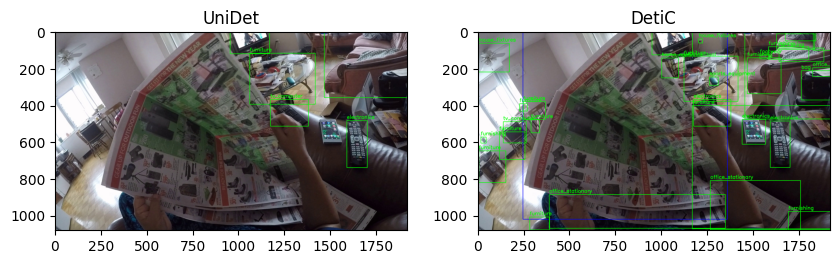

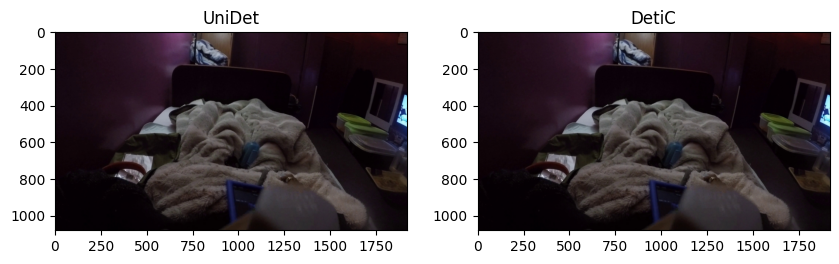

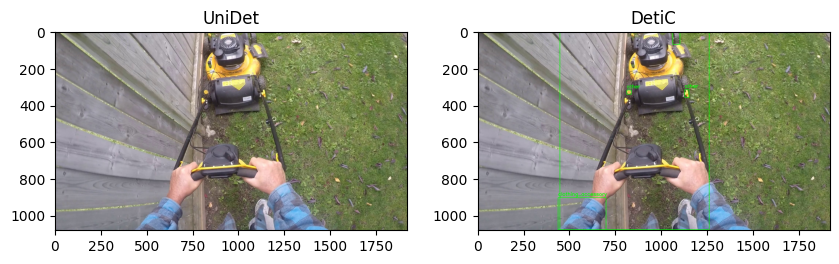

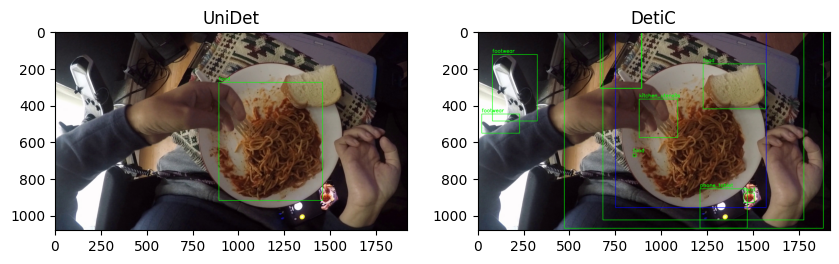

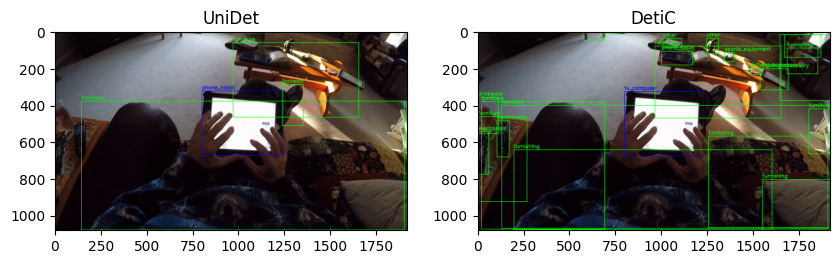

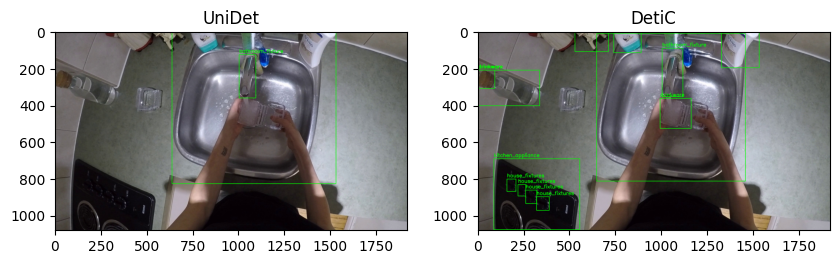

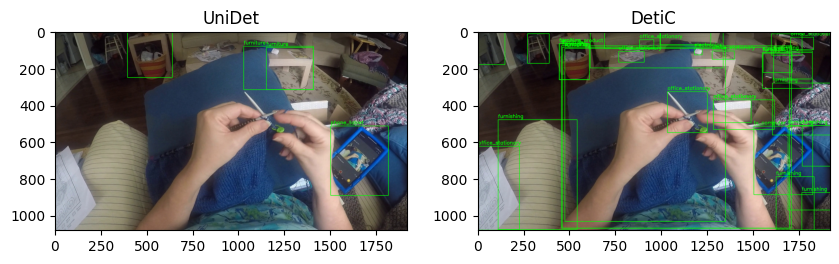

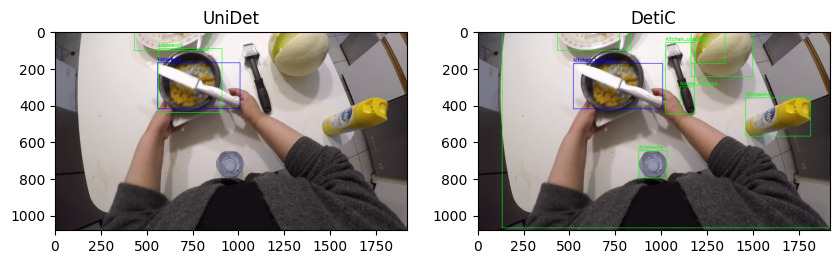

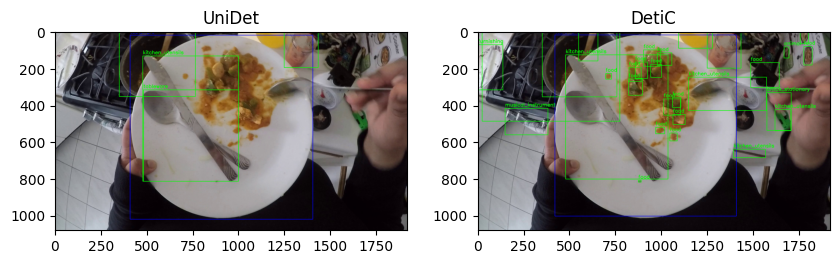

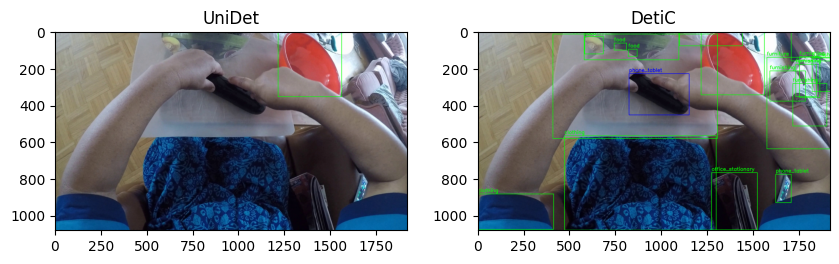

In [19]:
import cv2
import matplotlib.pyplot as plt
import random

def draw_boxes(img, boxes, labels, active, color_dict):
    for box, label, active in zip(boxes, labels, active):
        color = color_dict[active]
        cv2.rectangle(img, (box[0], box[1]), (box[2], box[3]), color, 2)
        cv2.putText(img, label, (box[0], box[1]-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, color, 2)

# select 10 random images
random_images = random.sample(list(all_data.items()), 10)

for img_name, img_data in random_images:
    adl_class, image_name = img_name.split('_', 1)  # separate the adl_class and image_name
    img_path = f"/content/drive/MyDrive/PhD/object-detection-eval-subset/dataset/{adl_class}/images/{image_name}.jpg"
    img = cv2.imread(img_path)
    img_unidet = img.copy()
    img_detic = img.copy()
    
    color_dict = {True: (255, 0, 0), False: (0, 255, 0)}  # red for active, green for non-active
    
    # draw unidet boxes
    draw_boxes(img_unidet, img_data['unidet_data']['boxes'], img_data['unidet_data']['labels'], img_data['unidet_data']['active'], color_dict)
    
    # draw detic boxes
    draw_boxes(img_detic, img_data['detic_data']['boxes'], img_data['detic_data']['labels'], img_data['detic_data']['active'], color_dict)
    
    plt.figure(figsize=(10,5))
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(img_unidet, cv2.COLOR_BGR2RGB))
    plt.title('UniDet')
    
    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(img_detic, cv2.COLOR_BGR2RGB))
    plt.title('Detic')
    
    plt.show()
